# Machine learning 

#### Importing the ML feeding table

In [1]:
from google.cloud import bigquery
import pandas as pd
from dotenv import load_dotenv
import os
from sklearn.cluster import KMeans
import numpy as np4
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

# Load environment variables from .env file
load_dotenv()

# Now you can use the environment variable
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")


# Create a BigQuery client
client = bigquery.Client()

# Your BigQuery query
query = """
SELECT * FROM `big-mamma-project.ML_tables.ML_table_7`
"""

# Run the query and convert it to a pandas dataframe
ml = client.query(query,location="EU").to_dataframe()

# Now df is a pandas DataFrame containing the results of the query
ml.drop(columns=['total_visits','total_cancellations','total_noshows','cash_payment','AFTERNOON','order_id'],inplace=True)
ml.head(10)

,End_of_week,Start_of_week,card_payment,invoice_payment,DINNER,LUNCH,actual_duration,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items
0,<NA>,1,1,<NA>,<NA>,<NA>,111,3,36.53,<NA>,6.0,6.0,6.0,11.0
1,<NA>,1,<NA>,1,1,<NA>,104,5,29.04,<NA>,4.0,3.0,0.0,7.0
2,<NA>,1,<NA>,1,<NA>,1,114,5,30.87,<NA>,3.0,3.0,1.0,4.0
3,1,1,1,<NA>,1,<NA>,217,5,48.31,<NA>,2.0,4.0,2.0,3.0
4,<NA>,1,<NA>,1,1,<NA>,38,2,30.91,<NA>,2.0,3.0,0.0,7.0
5,1,1,<NA>,1,<NA>,<NA>,142,2,67.58,1,3.0,3.0,0.0,7.0
6,<NA>,1,<NA>,1,1,<NA>,119,5,42.52,<NA>,3.0,6.0,4.0,9.0
7,<NA>,1,<NA>,<NA>,<NA>,<NA>,238,13,52.31,1,0.0,0.0,0.0,19.0
8,<NA>,1,<NA>,1,1,<NA>,61,2,27.32,<NA>,2.0,1.0,0.0,3.0
9,<NA>,1,<NA>,1,<NA>,1,49,2,36.66,<NA>,2.0,0.0,1.0,1.0


## DF preparation


#### Finding NAs

In [2]:
#Displaying NAs count per column
ml.isnull().sum()

End_of_week              280823
Start_of_week            356114
card_payment             617871
invoice_payment          205716
DINNER                   327557
LUNCH                    475056
actual_duration               0
covers                        0
revenue_per_cover             0
high_spender             622750
total_main_items          24636
total_starters_items      24636
total_desserts_items      24636
total_beverages_items     24636
dtype: int64

In [3]:
#Displaying types
ml.dtypes

End_of_week                Int64
Start_of_week              Int64
card_payment               Int64
invoice_payment            Int64
DINNER                     Int64
LUNCH                      Int64
actual_duration            Int64
covers                     Int64
revenue_per_cover        float64
high_spender               Int64
total_main_items         float64
total_starters_items     float64
total_desserts_items     float64
total_beverages_items    float64
dtype: object

#### Fill NAs with 0

In [4]:
# Fill missing values with the mean of each column
ml = ml.fillna(0)
ml.isnull().sum()

End_of_week              0
Start_of_week            0
card_payment             0
invoice_payment          0
DINNER                   0
LUNCH                    0
actual_duration          0
covers                   0
revenue_per_cover        0
high_spender             0
total_main_items         0
total_starters_items     0
total_desserts_items     0
total_beverages_items    0
dtype: int64

#### Removing outliers

#### Z-scores on whole DF

In [5]:
# Select numerical columns only 
numerical_columns = ml.select_dtypes(include=[np.number]).columns

# Calculate Z-scores for each numerical column
z_scores = np.abs((ml[numerical_columns] - ml[numerical_columns].mean()) / ml[numerical_columns].std())

# Define a threshold for outliers (e.g., Z-score > 3, meaning values beyond 3 standard deviations)
threshold = 3

# Create a boolean mask for outliers
outlier_mask = (z_scores > threshold).any(axis=1)

# Remove outliers from the DataFrame
ml_no_outliers = ml[~outlier_mask]

# Keep only the outliers
ml_outliers_only = ml[outlier_mask]

In [6]:
#Checking mean and std for original DF
ml.describe()

,End_of_week,Start_of_week,card_payment,invoice_payment,DINNER,LUNCH,actual_duration,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items
count,739422.0,739422.0,739422.0,739422.0,739422.0,739422.0,739422.0,739422.0,739422.000000,739422.0,739422.000000,739422.000000,739422.000000,739422.000000
mean,0.620213,0.518389,0.164387,0.721788,0.557009,0.357531,87.272829,6.211974,37.320521,0.157788,2.372257,1.556978,0.852099,3.483087
std,0.485334,0.499662,0.370626,0.448119,0.49674,0.479273,39.950278,1711.792468,24.146371,0.364542,1.769390,1.667153,1.319298,3.463193
min,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.010000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,61.0,2.0,25.880000,0.0,1.000000,0.000000,0.000000,2.000000
50%,1.0,1.0,0.0,1.0,1.0,0.0,81.0,2.0,34.020000,0.0,2.000000,1.000000,0.000000,3.000000
75%,1.0,1.0,0.0,1.0,1.0,1.0,106.0,3.0,43.960000,0.0,3.000000,2.000000,1.000000,4.000000
max,1.0,1.0,1.0,1.0,1.0,1.0,1305.0,999999.0,2007.330000,1.0,67.000000,71.000000,44.000000,304.000000


In [7]:
#Checking mean and std for new DF with outliers only
ml_outliers_only.describe()

,End_of_week,Start_of_week,card_payment,invoice_payment,DINNER,LUNCH,actual_duration,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items
count,45573.0,45573.0,45573.0,45573.0,45573.0,45573.0,45573.0,45573.0,45573.000000,45573.0,45573.000000,45573.000000,45573.000000,45573.000000
mean,0.639809,0.508437,0.25175,0.473043,0.594365,0.334057,142.674347,58.391811,59.933786,0.385338,4.958989,3.544489,2.876659,9.557326
std,0.480061,0.499934,0.434023,0.499278,0.49102,0.471665,79.01398,6894.936689,75.546328,0.48668,4.206772,3.712417,3.130362,8.280278
min,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.010000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,94.0,2.0,30.190000,0.0,2.000000,1.000000,0.000000,4.000000
50%,1.0,1.0,0.0,0.0,1.0,0.0,125.0,4.0,42.650000,0.0,4.000000,3.000000,2.000000,7.000000
75%,1.0,1.0,1.0,1.0,1.0,1.0,171.0,5.0,63.730000,1.0,8.000000,5.000000,5.000000,14.000000
max,1.0,1.0,1.0,1.0,1.0,1.0,1305.0,999999.0,2007.330000,1.0,67.000000,71.000000,44.000000,304.000000


In [8]:
#Checking mean and std for new DF w/o outliers
ml_no_outliers.describe()

,End_of_week,Start_of_week,card_payment,invoice_payment,DINNER,LUNCH,actual_duration,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items
count,693849.0,693849.0,693849.0,693849.0,693849.0,693849.0,693849.0,693849.0,693849.000000,693849.0,693849.000000,693849.000000,693849.000000,693849.000000
mean,0.618926,0.519042,0.158648,0.738126,0.554556,0.359072,83.633978,2.784727,35.835249,0.142842,2.202357,1.426436,0.719123,3.084122
std,0.485651,0.499638,0.365348,0.439655,0.497015,0.479729,32.80183,7.973512,14.515413,0.349912,1.306018,1.334261,0.961435,2.386559
min,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.010000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2.0,25.790000,0.0,1.000000,0.000000,0.000000,1.000000
50%,1.0,1.0,0.0,1.0,1.0,0.0,80.0,2.0,33.550000,0.0,2.000000,1.000000,0.000000,3.000000
75%,1.0,1.0,0.0,1.0,1.0,1.0,103.0,3.0,43.130000,0.0,3.000000,2.000000,1.000000,4.000000
max,1.0,1.0,1.0,1.0,1.0,1.0,207.0,4772.0,109.750000,1.0,7.000000,6.000000,4.000000,13.000000


#### Z-score on covers column

In [9]:
# Calculate Z-scores for each numerical column
z_scores = np.abs((ml_no_outliers['covers'] - ml_no_outliers['covers'].mean()) / ml_no_outliers['covers'].std())

# Define a threshold for outliers (e.g., Z-score > 3, meaning values beyond 3 standard deviations)
threshold =0.7

# Create a boolean mask for outliers
outlier_mask = (z_scores > threshold)

# Remove outliers from the DataFrame
ml_no_outliers2 = ml_no_outliers[~outlier_mask]

In [10]:
#Checking mean and std for new DF w/o outliers 2
ml_no_outliers2.describe()

,End_of_week,Start_of_week,card_payment,invoice_payment,DINNER,LUNCH,actual_duration,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items
count,690923.0,690923.0,690923.0,690923.0,690923.0,690923.0,690923.0,690923.0,690923.000000,690923.0,690923.000000,690923.000000,690923.000000,690923.000000
mean,0.618862,0.519111,0.157799,0.739948,0.554383,0.359343,83.45038,2.702397,35.773164,0.140657,2.206929,1.429688,0.720946,3.068611
std,0.485667,0.499635,0.364553,0.438663,0.497034,0.479808,32.602469,1.169627,14.420176,0.347667,1.300388,1.333140,0.961627,2.366618
min,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.010000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2.0,25.780000,0.0,1.000000,0.000000,0.000000,1.000000
50%,1.0,1.0,0.0,1.0,1.0,0.0,79.0,2.0,33.550000,0.0,2.000000,1.000000,0.000000,3.000000
75%,1.0,1.0,0.0,1.0,1.0,1.0,102.0,3.0,43.130000,0.0,3.000000,2.000000,1.000000,4.000000
max,1.0,1.0,1.0,1.0,1.0,1.0,207.0,8.0,109.750000,1.0,7.000000,6.000000,4.000000,13.000000


In [11]:
#Assigning new value to orignal DF to proceed with the analysis
ml=ml_no_outliers2

#### Correlation check and heatmap

Text(0.5, 1.0, 'Correlation Heatmap')

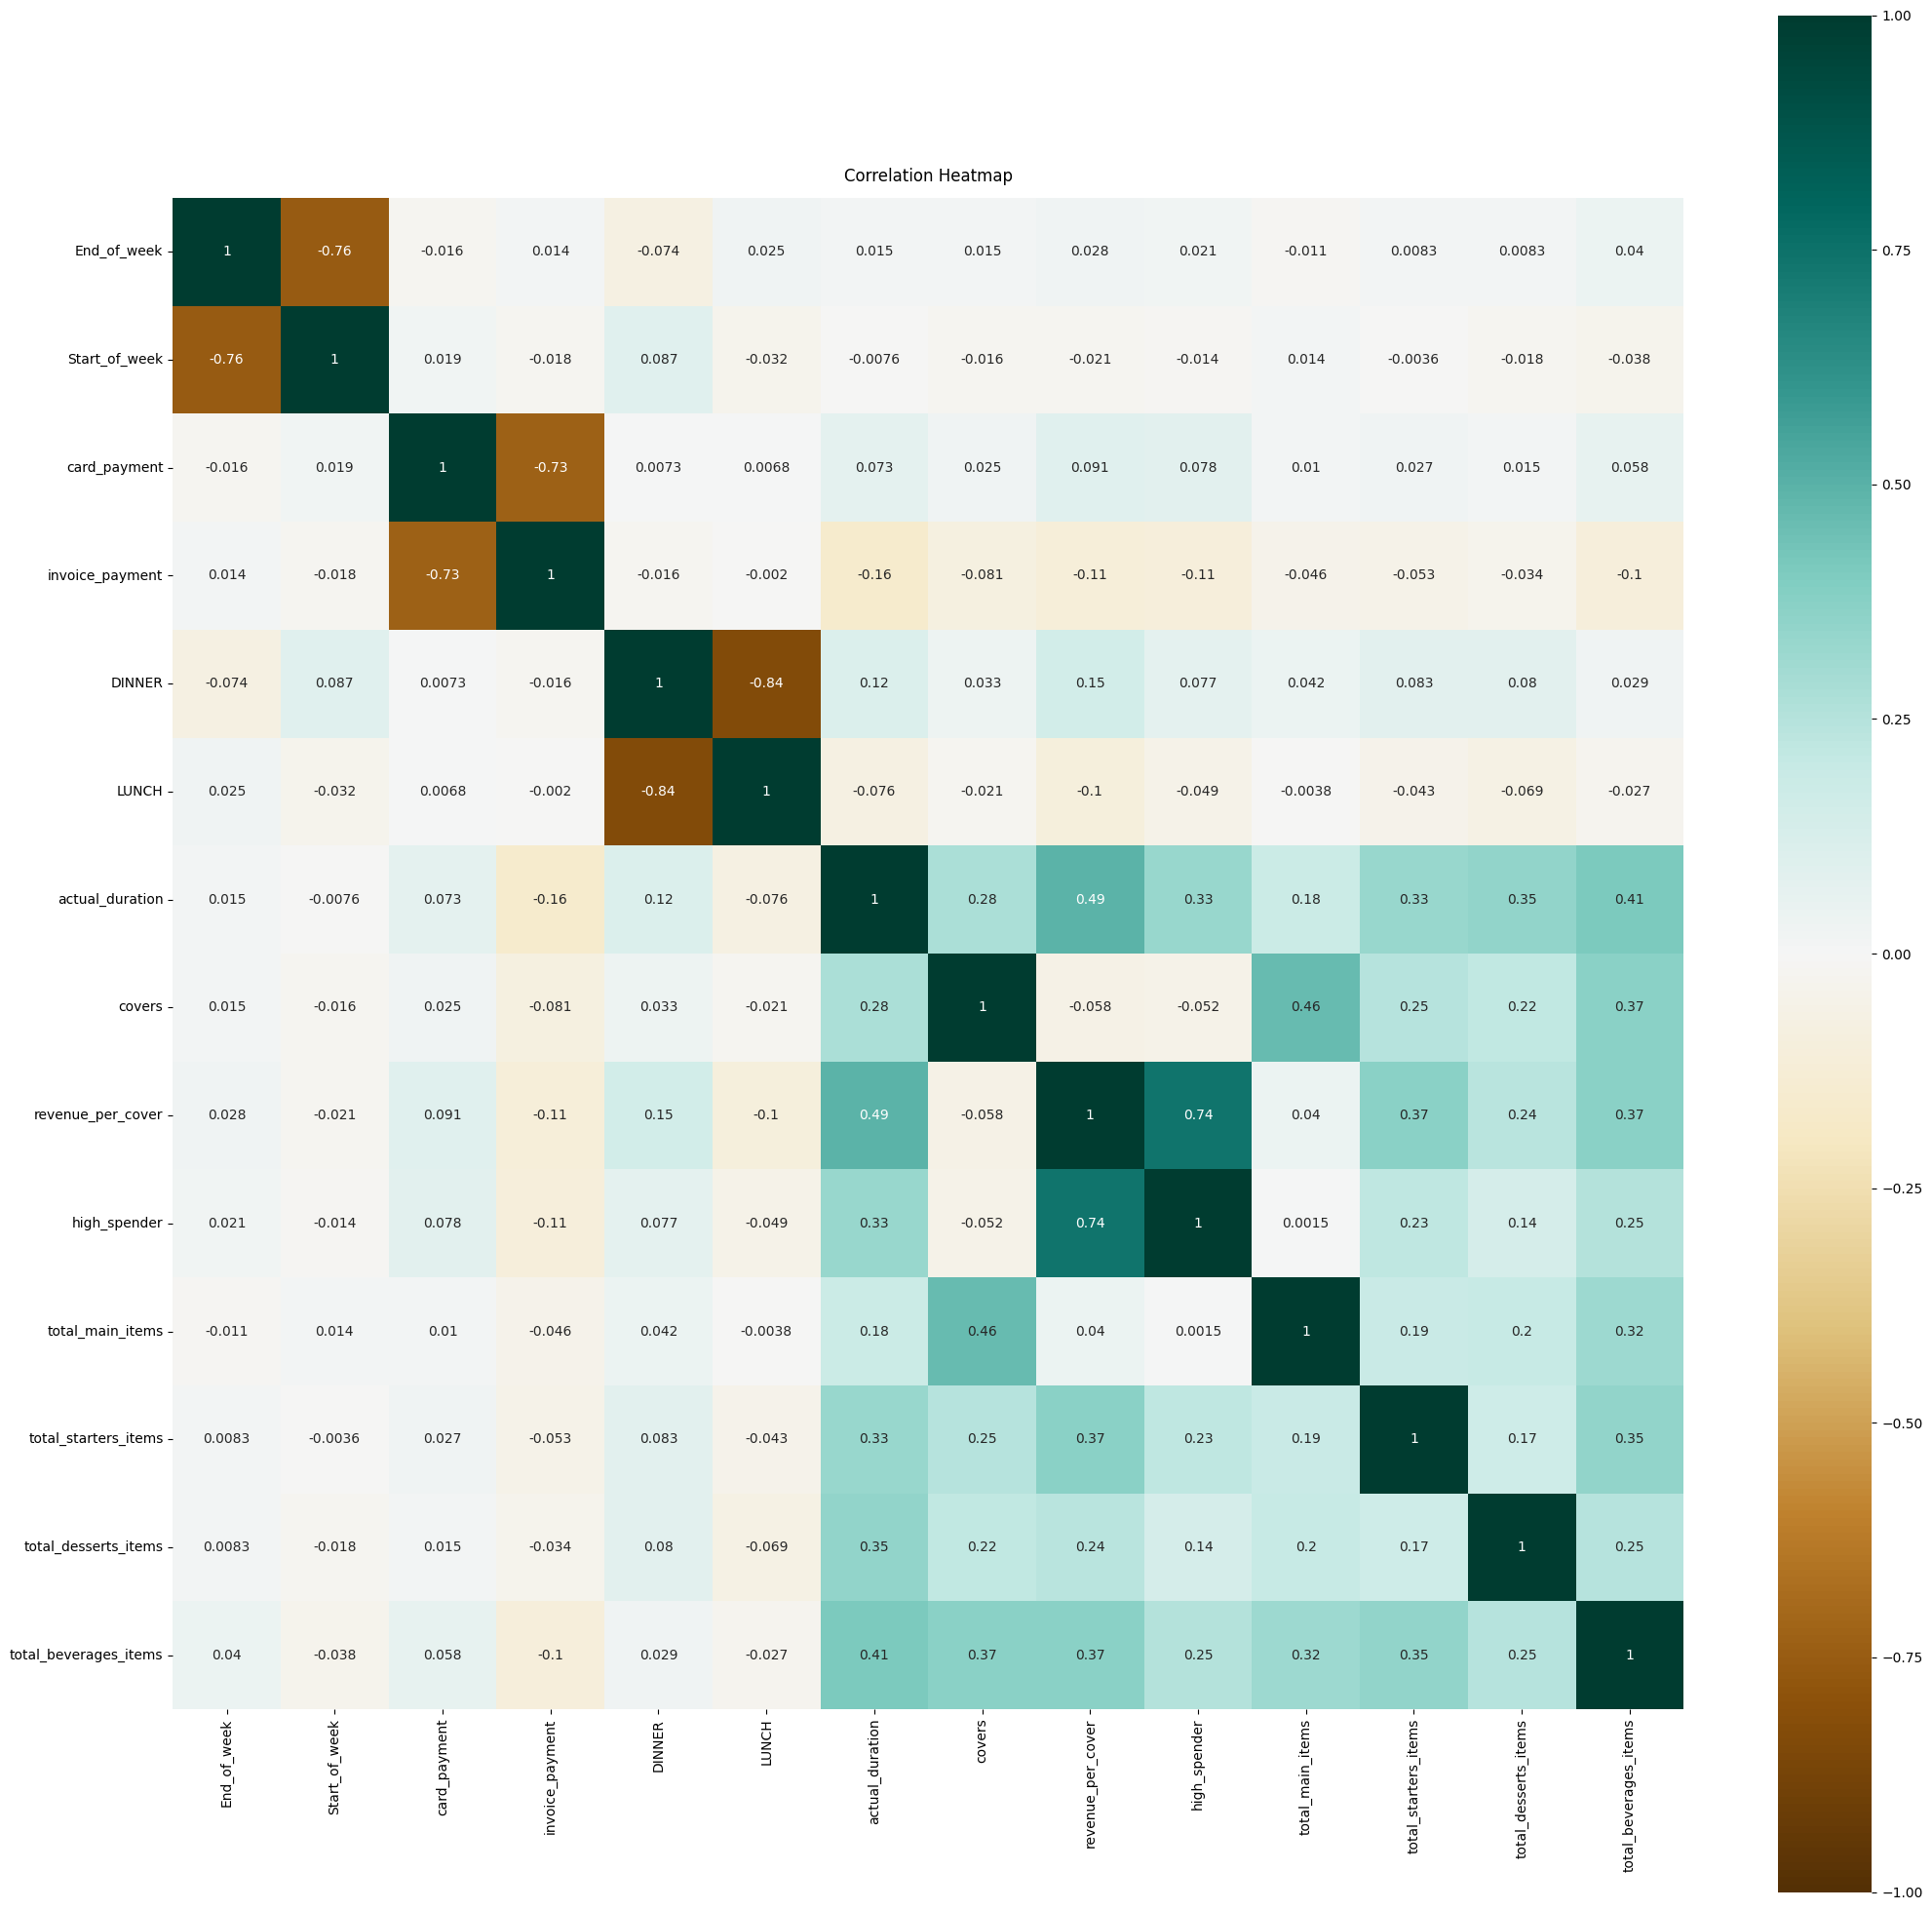

In [12]:
# Increase the size of the heatmap.
plt.figure(figsize=(25,25))

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(ml.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG',square=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

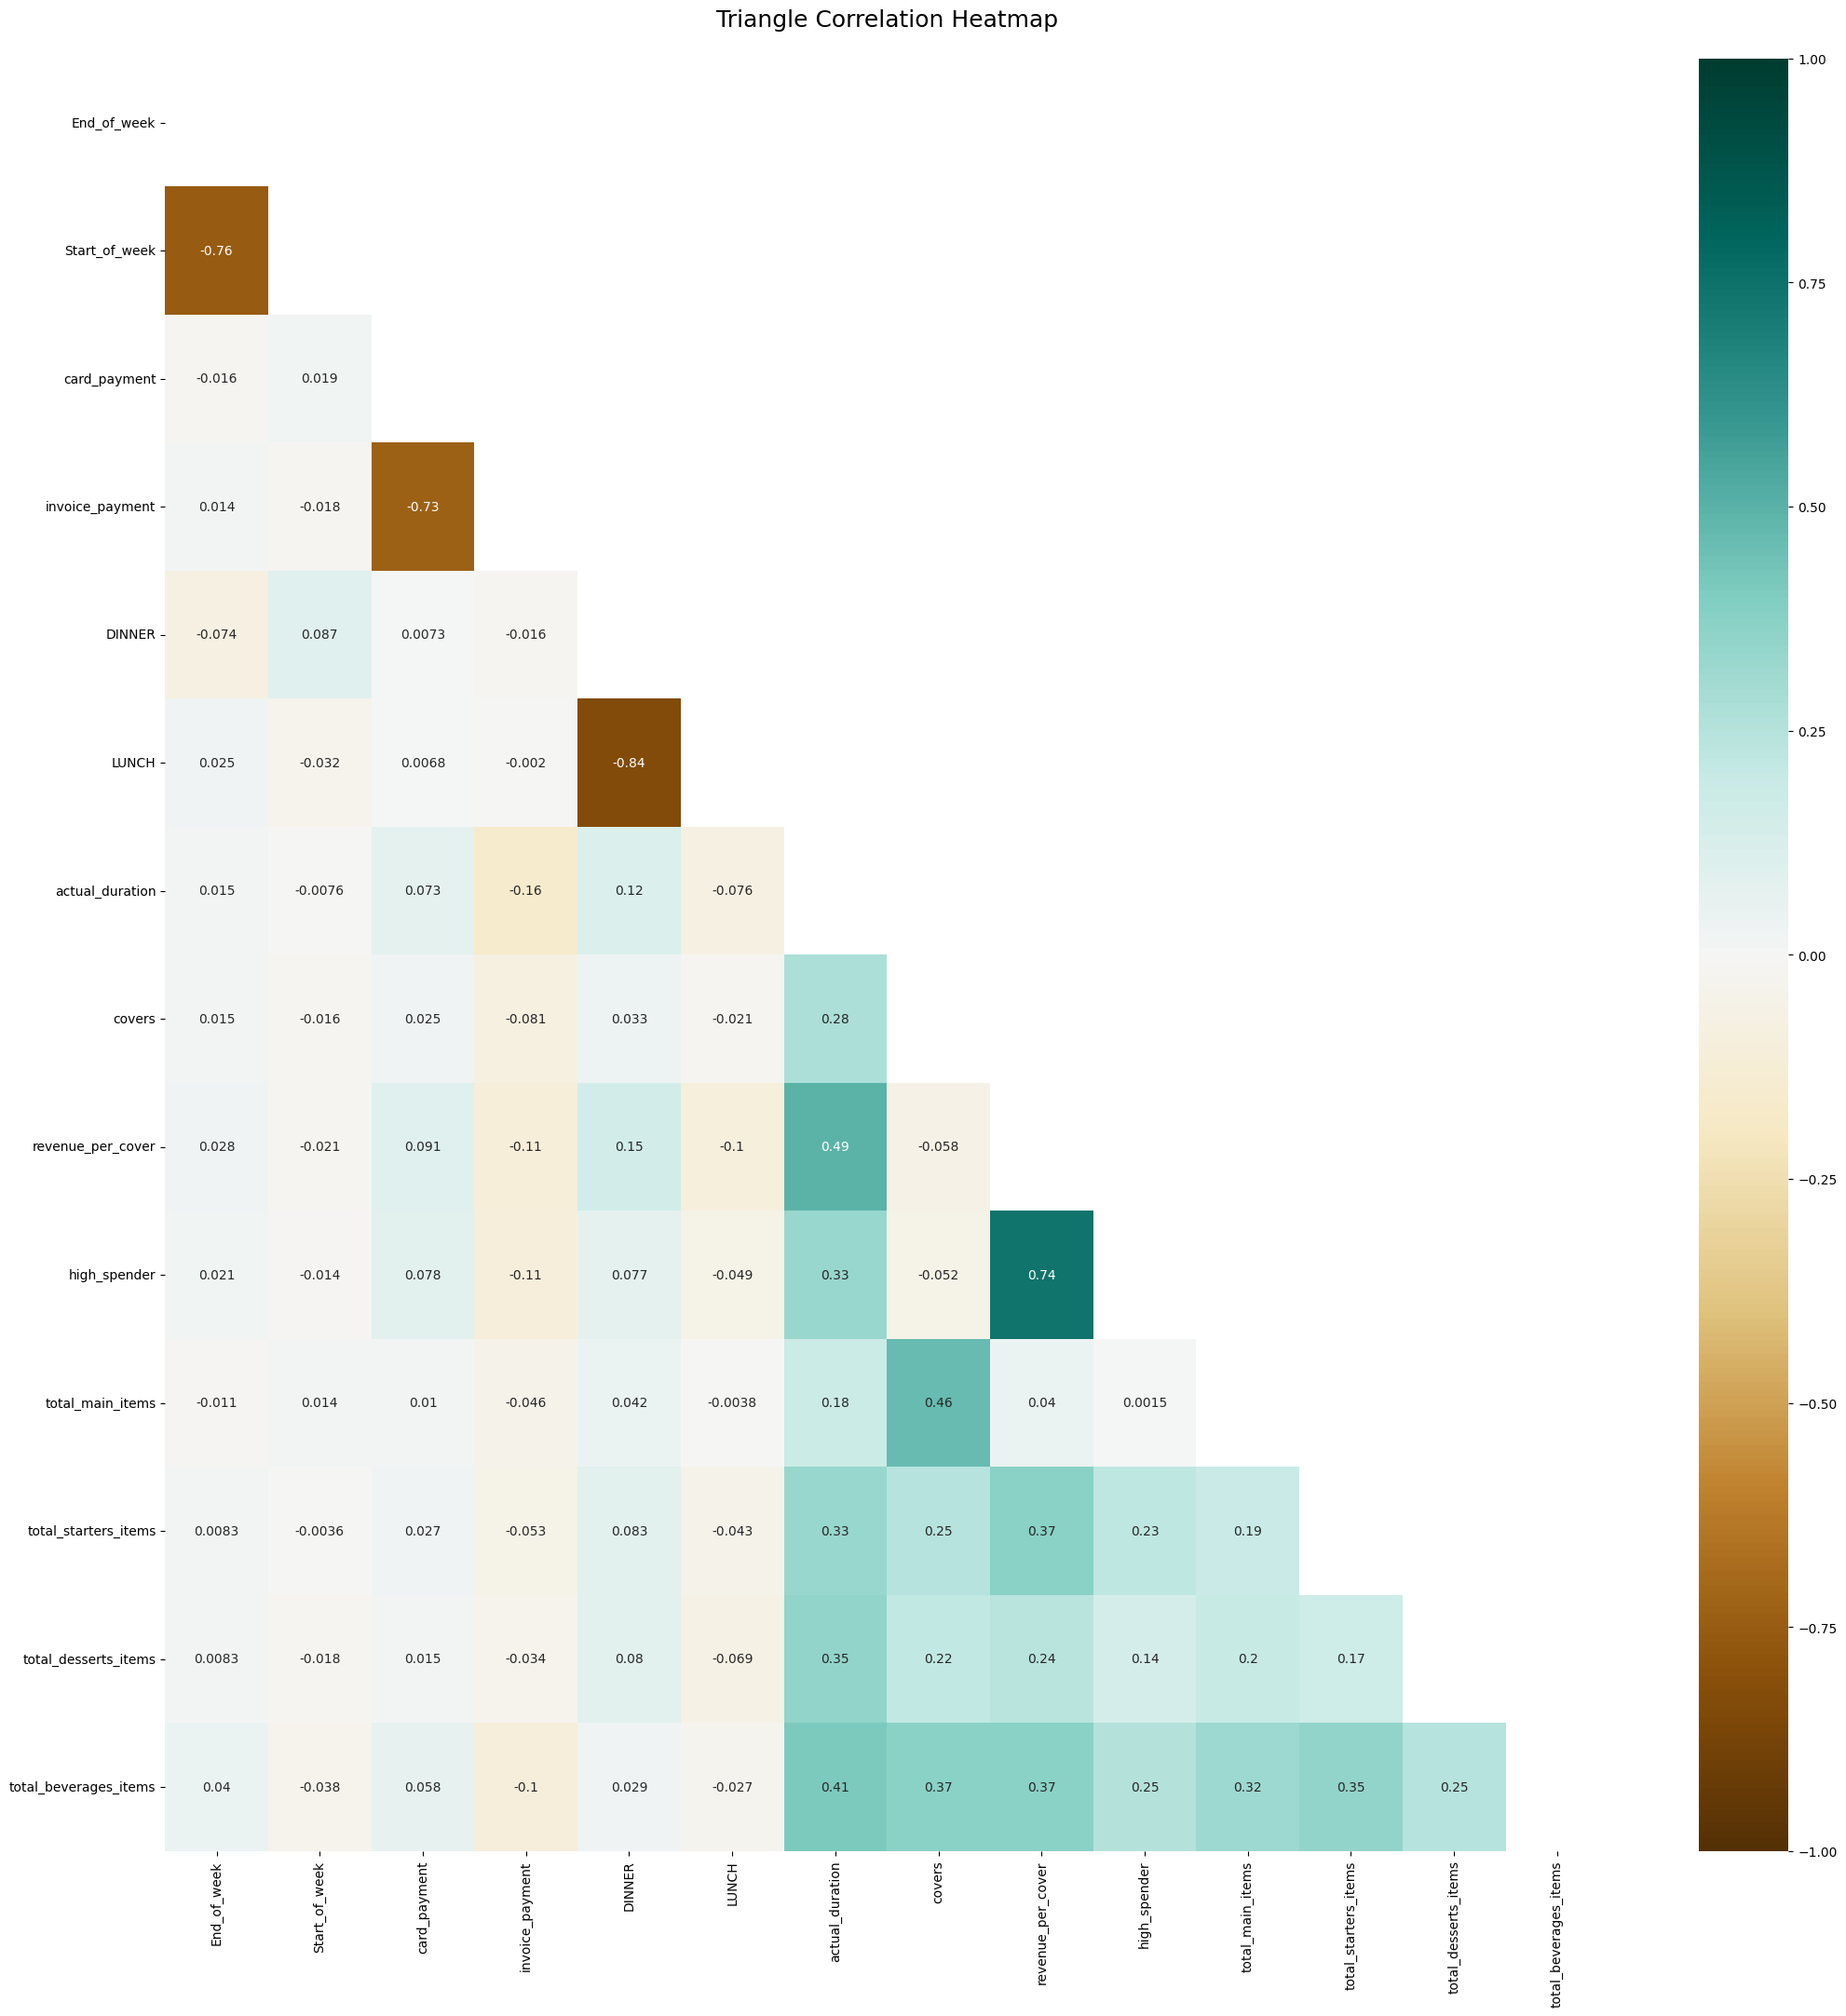

In [13]:
#Making a triangle heatmap for more lisibilty 
plt.figure(figsize=(25,25))

#Define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(ml.corr(), dtype=bool))
heatmap = sns.heatmap(ml.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=25)

#### Distribution check

In [14]:
#Quick distribution check
ml_distribution = pd.DataFrame(ml.sum(axis=0))
ml_distribution.rename(columns={0:'count'},inplace=True)
ml_distribution['percent'] = round((ml_distribution['count']/len(ml))*100,2)
ml_distribution.sort_values(by='percent',ascending=True)

,count,percent
high_spender,97183.0,14.07
card_payment,109027.0,15.78
LUNCH,248278.0,35.93
Start_of_week,358666.0,51.91
DINNER,383036.0,55.44
End_of_week,427586.0,61.89
total_desserts_items,498118.0,72.09
invoice_payment,511247.0,73.99
total_starters_items,987804.0,142.97
total_main_items,1524818.0,220.69


#### Scaling features


In [15]:
#Scaling the ML table and storing the output 

#Initializing and training scaler 
scaler=StandardScaler()
ml_scaled=scaler.fit_transform(ml)

In [16]:
#Checking our scaled features 
ml_scaled_df=pd.DataFrame(ml_scaled,columns=scaler.get_feature_names_out())
ml_scaled_df

,End_of_week,Start_of_week,card_payment,invoice_payment,DINNER,LUNCH,actual_duration,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items
0,-1.274253,0.962481,-0.432857,0.592829,0.896553,-0.748930,0.630309,1.964392,-0.466927,-0.404573,1.378875,1.177906,-0.749715,1.661185
1,-1.274253,0.962481,-0.432857,0.592829,-1.115383,1.335238,0.937035,1.964392,-0.340021,-0.404573,0.609873,1.177906,0.290190,0.393553
2,-1.274253,0.962481,-0.432857,0.592829,0.896553,-0.748930,-1.394079,-0.600531,-0.337247,-0.404573,-0.159129,1.177906,-0.749715,1.661185
3,0.784773,0.962481,-0.432857,0.592829,-1.115383,-0.748930,1.795866,-0.600531,2.205719,2.471741,0.609873,1.177906,-0.749715,1.661185
4,-1.274253,0.962481,-0.432857,0.592829,0.896553,-0.748930,1.090397,1.964392,0.467875,-0.404573,0.609873,3.428235,3.409905,2.506274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690918,-1.274253,0.962481,-0.432857,0.592829,0.896553,-0.748930,0.200894,-0.600531,1.804198,2.471741,-0.159129,0.427797,1.330095,-0.028991
690919,-1.274253,0.962481,-0.432857,0.592829,-1.115383,1.335238,-0.872646,-0.600531,-0.371228,-0.404573,-0.928131,-0.322313,0.290190,-0.874080
690920,0.784773,-1.038982,-0.432857,0.592829,-1.115383,-0.748930,0.446274,2.819366,-0.835855,-0.404573,1.378875,1.177906,-0.749715,-0.028991
690921,0.784773,0.962481,-0.432857,0.592829,0.896553,-0.748930,0.384929,-0.600531,-0.104240,-0.404573,-0.159129,-0.322313,1.330095,-0.451535


# Tests and model validity checks

#### Elbow method 

In [17]:
#Elbow method
inertias = []
n_k = range(1, 10)

# for each number of centroids
for k in n_k:
     kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(ml_scaled)
     inertias.append(kmeans.inertia_)
print(inertias )

[9672922.000000056, 8287151.798446841, 7462710.908036753, 6739506.469057677, 6148468.514610194, 5717977.540727223, 5551515.707919411, 5222719.56644424, 5083017.930194065]


In [18]:
#Plotting the inertias method 1 
fig = px.line(inertias)
fig.show()

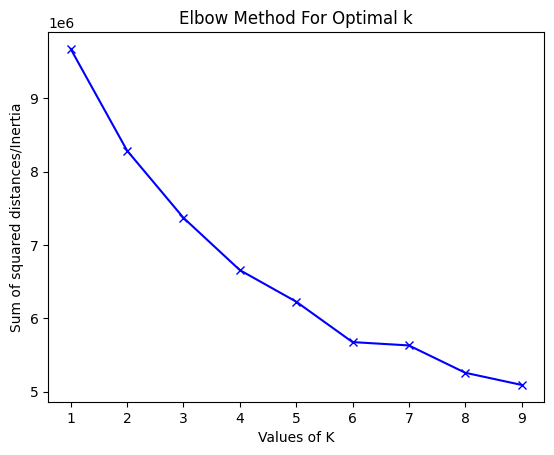

In [19]:
#Plotting the inertias method 2
Sum_of_squared_distances = []
K = range(1,10)

for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters,n_init="auto")
 kmeans.fit(ml_scaled)
 Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')

plt.show()

#### Scoring model : Calinski-Harabasz Index and Davies-Bouldin Index

In [20]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

#Lauching clustering prediction
kmeans = KMeans(n_clusters=5, random_state=12, n_init="auto").fit(ml_scaled)
labels_scaled=kmeans.predict(ml_scaled)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(ml_scaled, labels_scaled)
print(f"Davies-Bouldin Index: {db_index}")

# Calculate Calinski-Harabasz Index
ch_index = calinski_harabasz_score(ml_scaled, labels_scaled)
print(f"Calinski-Harabasz Index: {ch_index}")

Davies-Bouldin Index: 1.7768849905284398
Calinski-Harabasz Index: 98064.35264100065


Davies-Bouldin Index (DBI):

The DBI measures the compactness and separation of clusters. A lower DBI indicates better clustering, where clusters are well-defined and separated.
The index is calculated based on the average similarity between each cluster and its most similar cluster, normalized by the average dissimilarity between the clusters.
A lower DBI is desirable, and the range of values is not bounded.

Calinski-Harabasz Index (CHI):

The CHI, also known as the Variance Ratio Criterion, measures the ratio of the between-cluster variance to the within-cluster variance. Higher values indicate better-defined and more separated clusters.
It considers both the distance between cluster centers (numerator) and the spread or dispersion of points within clusters (denominator).
A higher CHI is indicative of better clustering, and the range of values is not bounded.

Interpretation:

The combination of a low DBI and a high CHI is generally favorable. It suggests that your clustering algorithm has produced clusters that are both compact and well-separated.

#### First clustering test 

labels
0    187727
1    125863
2    193070
3     95947
4     88316
Name: labels, dtype: int64


C:\Users\bermo\AppData\Local\Temp\ipykernel_13500\2465195791.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='labels', ylabel='count'>

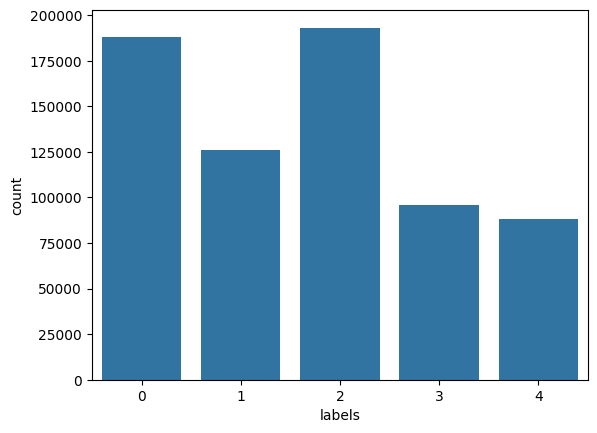

In [21]:
#Applying labels to the original dataframe
ml['labels']=labels_scaled
ml_scaled_df['labels']=labels_scaled
ml_distrib=ml.groupby('labels',as_index=True)['labels'].count()

#Printing number + graph to vizualize 
print(ml_distrib)
sns.countplot(ml,x='labels')

# Exploring results

## Heatmap

In [22]:
#Creating heatmap
cm = sns.light_palette("green", as_cmap=True)

#a remettre en ml au lieu de ml_scaled
ml.groupby('labels')[ml.columns[:-1]].mean().style.background_gradient(cmap=cm)

,End_of_week,Start_of_week,card_payment,invoice_payment,DINNER,LUNCH,actual_duration,covers,revenue_per_cover,high_spender,total_main_items,total_starters_items,total_desserts_items,total_beverages_items
labels,,,,,,,,,,,,,,
0,0.637426,0.501228,0.000000,0.892503,0.000000,0.992233,74.552195,2.664129,29.741000,0.002722,2.178174,1.211930,0.567611,2.669739
1,0.000000,1.000000,0.000000,0.885876,0.908885,0.000000,81.011878,2.717185,32.161000,0.002264,2.224403,1.352010,0.723390,2.737747
2,1.000000,0.221086,0.000000,0.891091,0.818946,0.000000,80.004548,2.745859,32.257274,0.000523,2.187253,1.331957,0.707764,2.880696
3,0.648556,0.499359,0.215859,0.626992,0.652225,0.296862,111.560622,2.589951,62.099826,0.987941,2.258341,2.239622,1.080690,4.704910
4,0.595894,0.544771,1.000000,0.000000,0.542914,0.379614,82.833733,2.789812,32.827902,0.016939,2.230309,1.336994,0.681383,3.021117


## Scatter plots

#### PCA in order to vizualise in 2D/3D

In [23]:
# Extract features and cluster labels
X = ml_scaled_df.drop('labels', axis=1)  
y = ml_scaled_df['labels']

# Apply PCA to reduce dimensionality to 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create a DataFrame with the reduced features and labels 
ml_pca = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])
ml_pca['labels'] = y

### 2D

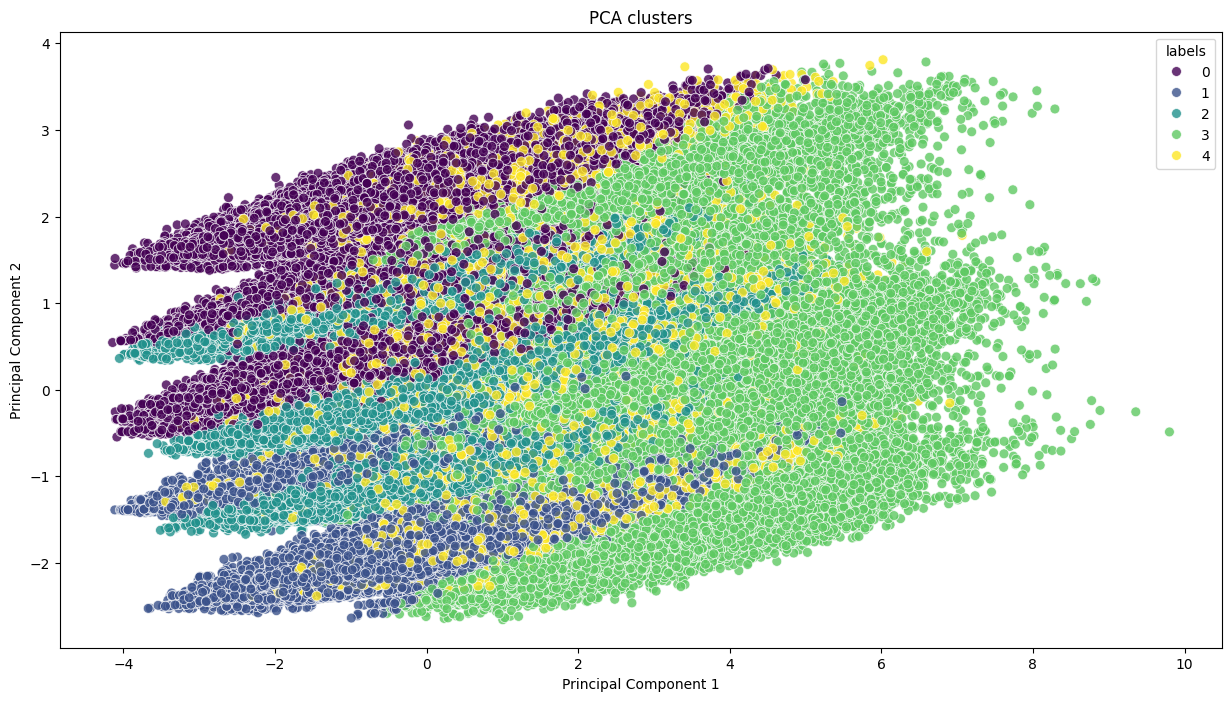

In [24]:
# Scatter plot using seaborn's hue parameter
plt.figure(figsize=(15, 8))
sns.scatterplot(data=ml_pca, x='Principal Component 1', y='Principal Component 2', hue='labels', palette='viridis', s=50, alpha=0.8, edgecolors='w')

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA clusters')

# Show the plot
plt.show()

#### 2D with centroids

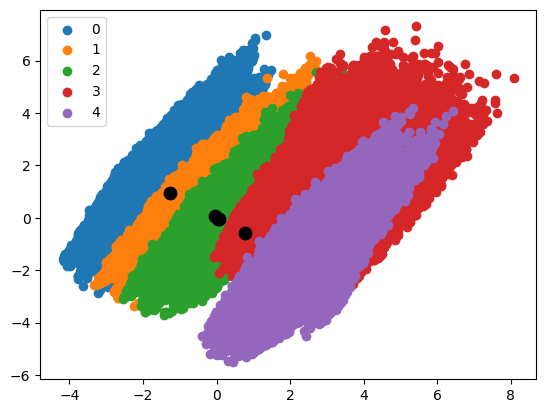

In [25]:
#Transform the data
pca = PCA(2)
ml_results= pca.fit_transform(ml_scaled_df)

#Getting the Centroids
centroids = kmeans.cluster_centers_

#Getting unique labels
u_labels = np.unique(labels_scaled)
 
for i in u_labels:
    plt.scatter(ml_results[labels_scaled == i , 0] , ml_results[labels_scaled == i , 1] , label= i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

### 3D

#### 3D from above

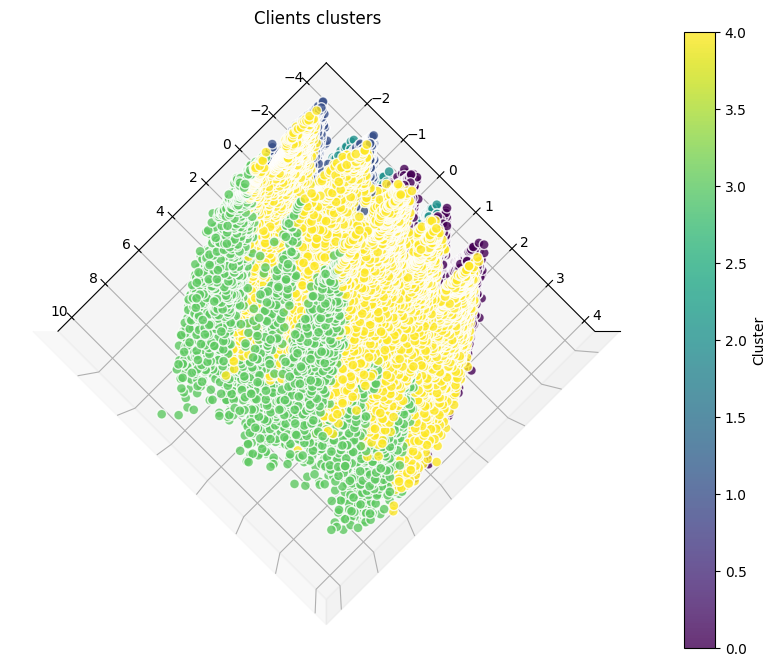

In [26]:
# 3D Scatter plot using seaborn's hue parameter
plt.figure(figsize=(15, 8))
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(ml_pca['Principal Component 1'], ml_pca['Principal Component 2'], ml_pca['Principal Component 3'], c=ml_pca['labels'], cmap='viridis', s=50, alpha=0.8, edgecolors='w')

# Add labels and title
# ax.set_xlabel('Principal Component 1')
# ax.set_ylabel('Principal Component 2')
# ax.set_zlabel('Principal Component 3')
ax.set_zticks([])
ax.set_title('Clients clusters')

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

#View angle parameters
ax.view_init(elev=90, azim=45)

# Show the plot
plt.show()

#### 3D from below

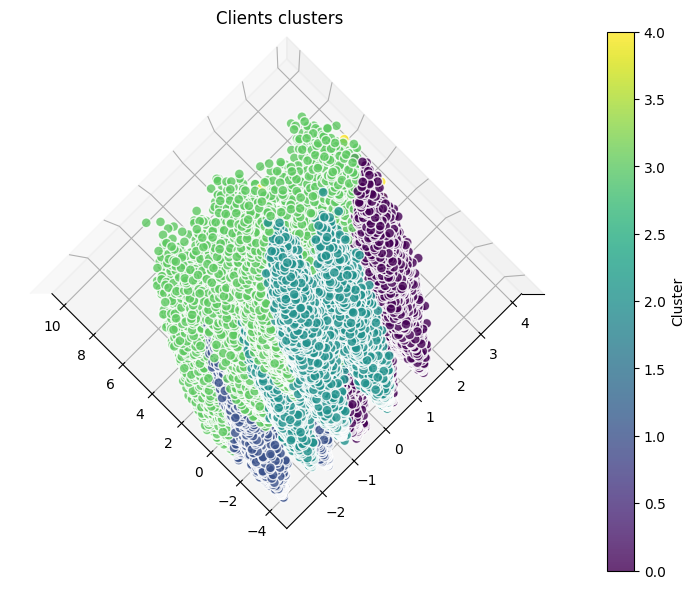

In [27]:
# 3D Scatter plot using seaborn's hue parameter
plt.figure(figsize=(15, 7))
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(ml_pca['Principal Component 1'], ml_pca['Principal Component 2'], ml_pca['Principal Component 3'], c=ml_pca['labels'], cmap='viridis', s=50, alpha=0.8, edgecolors='w')

# Add labels and title
    # ax.set_xlabel('Principal Component 1')
    # ax.set_ylabel('Principal Component 2')
    # ax.set_zlabel('Principal Component 3')
ax.set_zticks([])
ax.set_title('Clients clusters')

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

#View angle parameters
ax.view_init(elev=-90, azim=45)

# Show the plot
plt.show()